In [79]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

class DirectionalChange:
    '''
    DC class: 
    Capable of reading a pd.DataFrame object, transforming it into DC series,
    tagged with ongoing event(up_DC,down_DC,up_OS,down_OS).
    Moreover, it can also 
    plot the DC upon the TS views with self.plotDC, with any given threshold;
    calculate DC-based indicators, like aTMV,Coastline,NDC,aR with any given threshold;
    '''

    def __init__(self, data):
        '''
        data: pd.DataFrame of open/high/close/low time series data.
        '''
        self.data = data
        
    def dc_pattern(self, threshold):
        '''
        Directional Change transformation
        '''
        # Initiation
        event_dict = [True]
        state_dict = ['up_OS']
        ph = self.data['Close'][0]
        ph_idx = 0
        pl = self.data['Close'][0]
        pl_idx = 0

        # Recording iteration
        for idx in range(1, len(self.data)):
            # Iterating the TS data
            
            if event_dict[-1]:
                # If the last event flag is True: uptrend confirmed
                
                if self.data['Close'][idx] <= (ph * (1 - threshold)):
                    # And if current close value is less than (last hightest record*(1-threshold))
                    
                    if state_dict[-1]!='up_DC':
                        # Also if the last state if not upward DC event, the predefined OS event flag should be reset.
                        
                        for i in range(ph_idx+1 , len(event_dict)):
                            event_dict[i] = False
                            state_dict[i] = "down_DC"
                            
                    # The event flag is flipped from True to False, a downward DC event is recorded
                    state_dict.append('down_DC')
                    event_dict.append(False) 
                    
                    # Store the current close value and TS index as the lowest record.
                    pl = self.data['Close'][idx]
                    pl_idx = idx

                else:
                    # No DC event founded yet, the last event flag should pass into current one.
                    
                    if state_dict[-1] == 'up_DC':
                        # if last state is upward DC event, current sate should be changed into upward OS event.
                        state_dict.append('up_OS')
                    else:
                        # if last state is upward OS event, continue
                        state_dict.append(state_dict[-1])
                    # Continue with last event flag
                    event_dict.append(event_dict[-1]) 
                    
                    if ph < self.data['Close'][idx]:
                        # if current close value is higher than record, update the record
                        ph = self.data['Close'][idx]
                        ph_idx = idx

            else:
                # Same as above
                if self.data['Close'][idx] >= (pl * (1 + threshold)):
                    
                    if state_dict[-1]!='down_DC':
                        
                        for i in range(pl_idx+1 , len(event_dict)):
                            event_dict[i] = True
                            state_dict[i] = "up_DC"

                    event_dict.append(True)
                    state_dict.append('up_DC')
                    
                    ph = self.data['Close'][idx]
                    ph_idx = idx

                else:
                    
                    if state_dict[-1] == 'down_DC':
                        state_dict.append('down_OS')
                    else:
                        state_dict.append(state_dict[-1])
                        
                    event_dict.append(event_dict[-1]) 

                    if pl > self.data['Close'][idx]:
                        pl = self.data['Close'][idx]
                        pl_idx = idx

        event_dict = list(zip(event_dict, state_dict))
        return pd.DataFrame(event_dict, index=[self.data.index],
                            columns=['DC:Threshold{}'.format(threshold), 'State:Threshold{}'.format(threshold)])  # Dict

    def plotDC(self, threshold, plot=True):
        '''
        Visualizing DC upon TS data.
        '''
        df = self.dc_pattern(threshold)
        
        df['ts'] = list(self.data['Close'])
        df['shift'] = df.iloc[:, 1].shift(-1)
        begin = df.iloc[0, :]
        listPlot = [df.index[0][0], begin['ts']]
        if plot: plt.figure(figsize=(25, 12))
        self.listExtreme = [listPlot]
        x_all = df['ts']
        if plot: plt.plot(x_all.index.map(lambda x: x[0]), x_all, 'cornflowerblue')
        for idx, row in df.iterrows():

            if idx == 0:
                continue
            time_str = idx[0].to_pydatetime().date()
            if row[1] == 'up_OS' and row[-1] == 'down_DC':
                self.listExtreme.append([idx[0], row['ts']])
                if plot: 
                    plt.plot([listPlot[0], idx[0]], [listPlot[1], row['ts']], 'lightgreen')
                listPlot = [idx[0], row['ts']]
                
            if row[1] == 'down_DC' and row[-1] == 'down_OS':
                if plot: 
                    plt.plot([listPlot[0], idx[0]], [listPlot[1], row['ts']], 'tomato')
                listPlot = [idx[0], row['ts']]
                
            if row[1] == 'down_OS' and row[-1] == 'up_DC':
                self.listExtreme.append([idx[0], row['ts']])
                if plot: 
                    plt.plot([listPlot[0], idx[0]], [listPlot[1], row['ts']], 'lightgreen')
                listPlot = [idx[0], row['ts']]
                
            if row[1] == 'up_DC' and row[-1] == 'up_OS':
                if plot: 
                    plt.plot([listPlot[0], idx[0]], [listPlot[1], row['ts']], 'tomato')
                listPlot = [idx[0], row['ts']]
                
            if row[1] == 'up_DC' and row[-1] == 'down_DC':
                self.listExtreme.append([idx[0],row['ts']])
                if plot: plt.plot([listPlot[0], idx[0]], [listPlot[1], row['ts']], 'tomato')
                listPlot = [idx[0], row['ts']]
                
            if row[1] == 'down_DC' and row[-1] == 'up_DC':
                self.listExtreme.append([idx[0],row['ts']])
                if plot: plt.plot([listPlot[0], idx[0]], [listPlot[1], row['ts']], 'tomato')
                listPlot = [idx[0], row['ts']]
                
        if plot: plt.plot([listPlot[0], idx[0]], [listPlot[1], row['ts']], 'lightgreen')
        self.listExtreme.append([idx[0], row['ts']])
        
        if plot: plt.show()

    def calculateATMV(self, threshold):
        aTMV = []
        self.plotDC(threshold, plot=False)
        previous = self.listExtreme[0]
        for turningPoint in self.listExtreme[1:]:
            currentATMV = (turningPoint[1] - previous[1]) / previous[1] / threshold

            aTMV.append([[previous[0], turningPoint[0]], np.abs(currentATMV)])
            previous = turningPoint
        return aTMV

    def calculateAR(self, threshold):
        aTMV = self.calculateATMV(threshold)
        aR = list(map(lambda x: x[1] / ((x[0][1] - x[0][0]).days), aTMV))
        timeSpan = list(zip(*aTMV))[0]
        aR = list(zip(timeSpan, aR))
        return aR

    def calculateCoastline(self, threshold):
        aTMV = self.calculateATMV(threshold)
        Coastline = sum(list(zip(*aTMV))[1])

        return Coastline
    def calculateNDC(self,threshold):
        return len(self.calculateATMV(threshold))




In [80]:
'''
Load the excel file as pd.DataFrame, and store each index TS data into [dictDfData] with their name as key.
'''
df_idx=pd.read_excel('DailyClosing-SelectedIndices-2019to2021.xlsx',sheet_name='Indices').iloc[:,1:]
dictDfData={}
for i in df_idx['Index']:
    dictDfData[i]=pd.read_excel('DailyClosing-SelectedIndices-2019to2021.xlsx',sheet_name=i)
    dictDfData[i]["Date"] = pd.to_datetime(dictDfData[i]["Date"],format="%Y%m%d")
    dictDfData[i].set_index("Date", inplace=True)

In [81]:
'''
Turn all index DataFrame into DC objects
'''
DCs={}
for key in dictDfData.keys():
    DCs[key]=DirectionalChange(dictDfData[key][["Close"]])

<IPython.core.display.Javascript object>


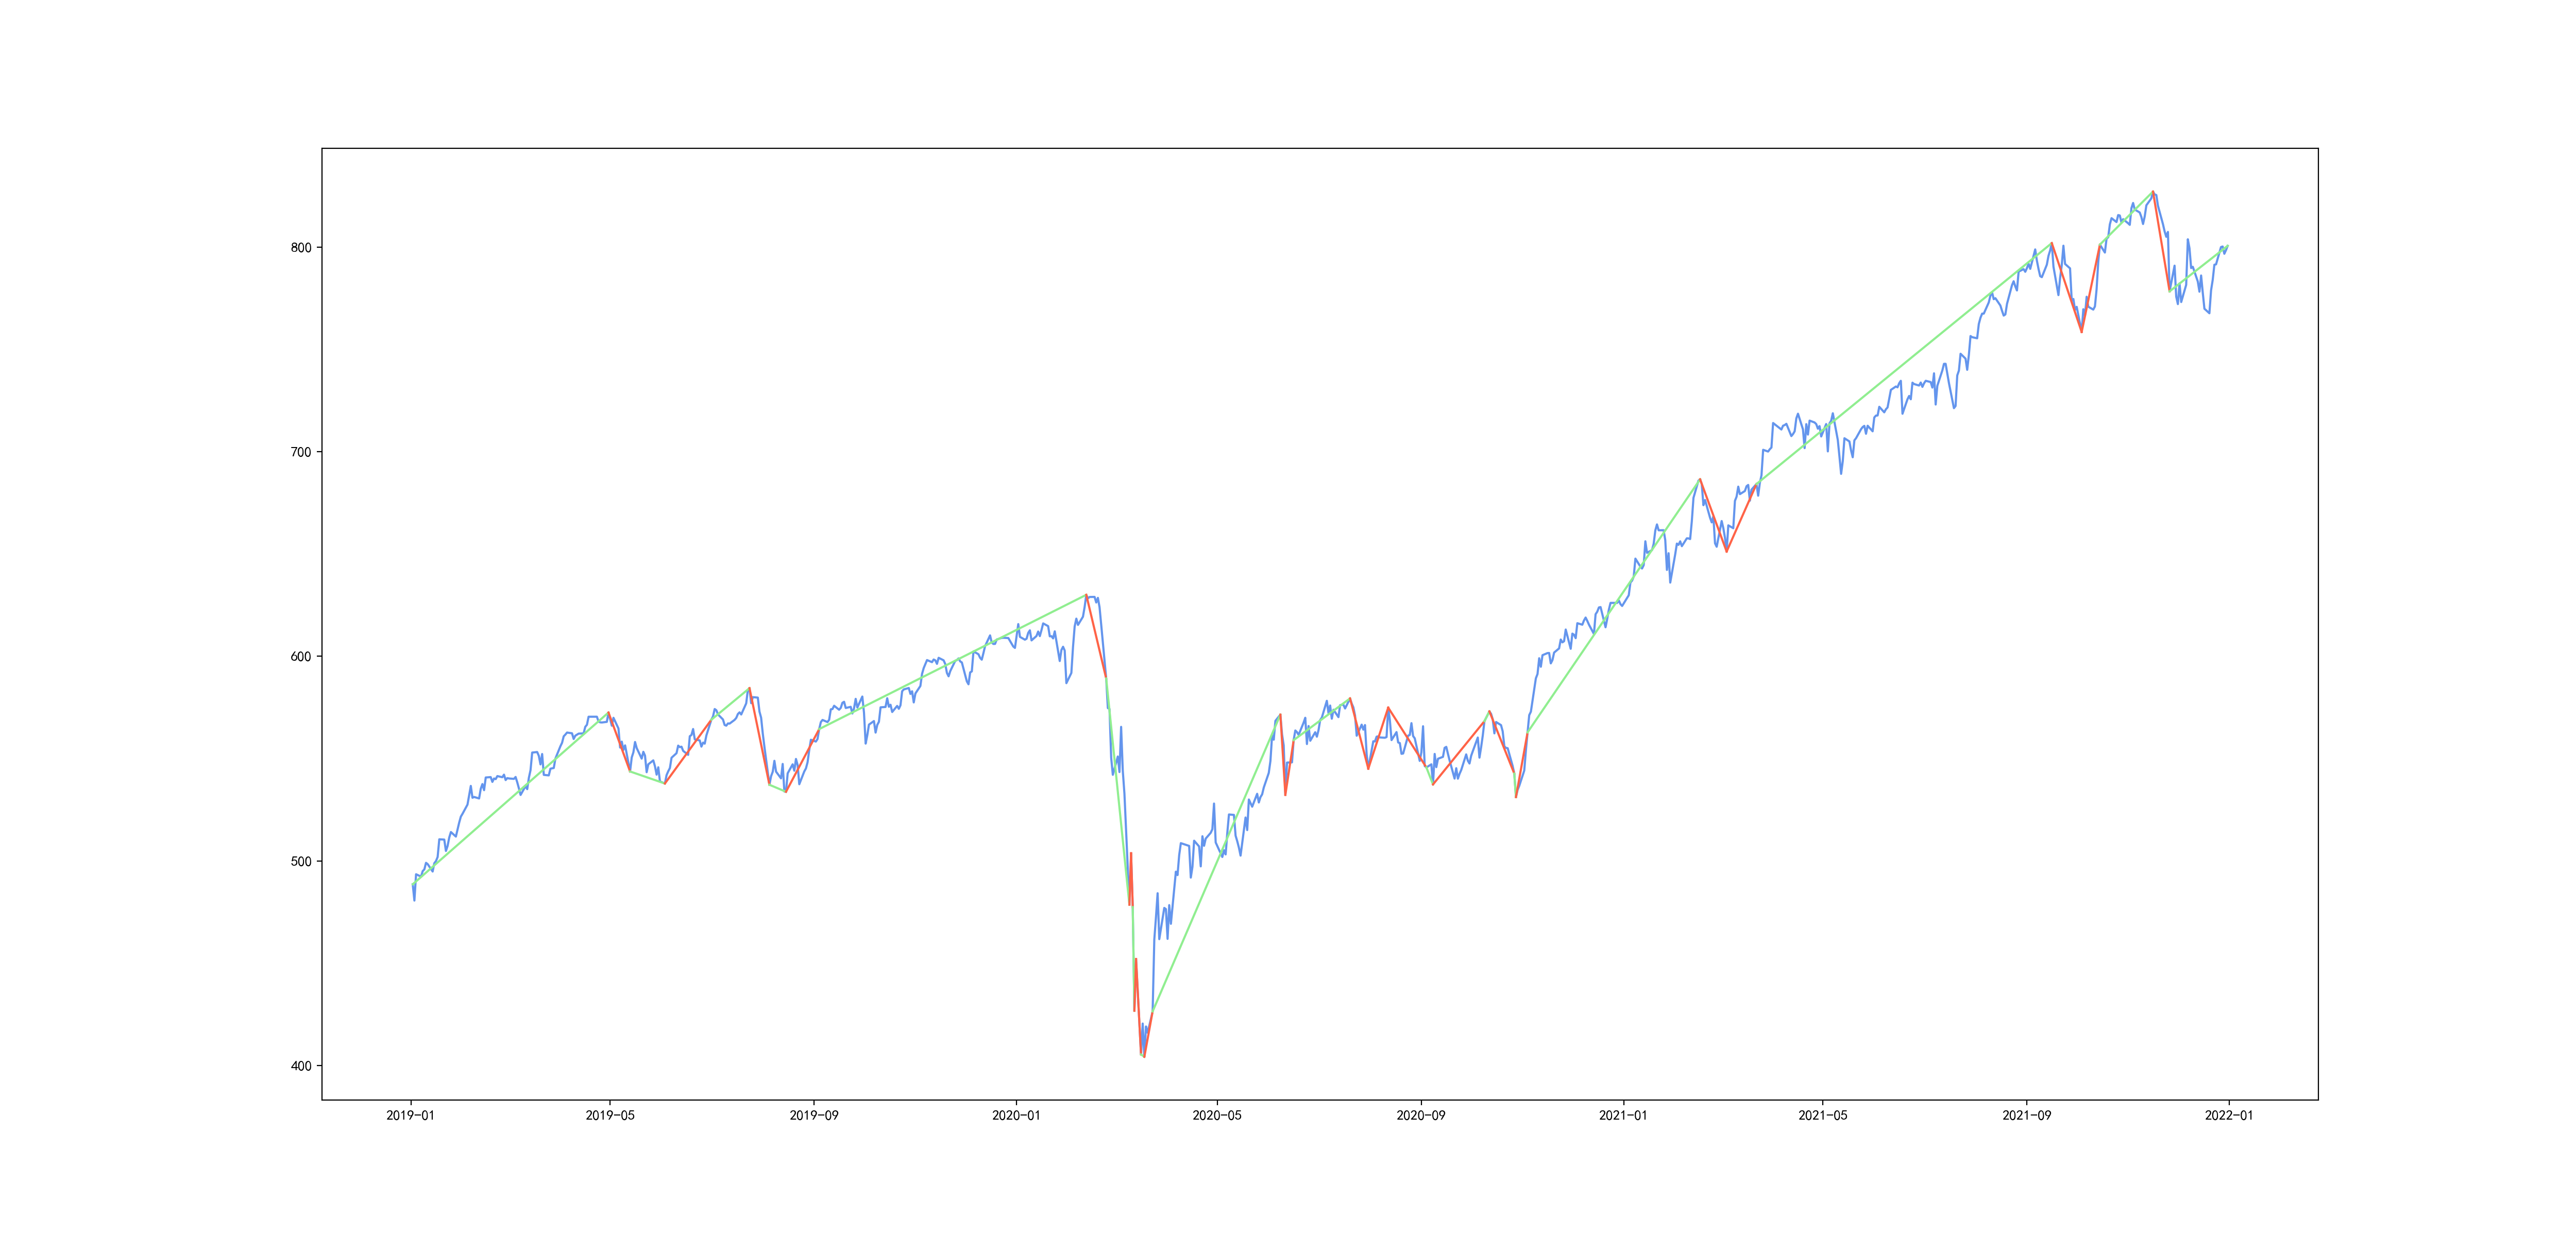

In [82]:
DCs['AEX25'].plotDC(0.05)

In [83]:
DCs['AEX25'].calculateATMV(0.05)

[[[Timestamp('2019-01-02 00:00:00'), Timestamp('2019-04-30 00:00:00')],
  3.436762481398924],
 [[Timestamp('2019-04-30 00:00:00'), Timestamp('2019-06-03 00:00:00')],
  1.2122662437248695],
 [[Timestamp('2019-06-03 00:00:00'), Timestamp('2019-07-24 00:00:00')],
  1.733739682445235],
 [[Timestamp('2019-07-24 00:00:00'), Timestamp('2019-08-15 00:00:00')],
  1.733351356993379],
 [[Timestamp('2019-08-15 00:00:00'), Timestamp('2020-02-12 00:00:00')],
  3.6076790060082353],
 [[Timestamp('2020-02-12 00:00:00'), Timestamp('2020-03-09 00:00:00')],
  4.808507261328465],
 [[Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00')],
  1.0500867166767665],
 [[Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-12 00:00:00')],
  3.056083319932419],
 [[Timestamp('2020-03-12 00:00:00'), Timestamp('2020-03-13 00:00:00')],
  1.1826681976894045],
 [[Timestamp('2020-03-13 00:00:00'), Timestamp('2020-03-18 00:00:00')],
  2.113177155702667],
 [[Timestamp('2020-03-18 00:00:00'), Timestamp('2020-06-

In [84]:
DCs['AEX25'].calculateAR(0.05)

[([Timestamp('2019-01-02 00:00:00'), Timestamp('2019-04-30 00:00:00')],
  0.029125105774567155),
 ([Timestamp('2019-04-30 00:00:00'), Timestamp('2019-06-03 00:00:00')],
  0.03565488952131969),
 ([Timestamp('2019-06-03 00:00:00'), Timestamp('2019-07-24 00:00:00')],
  0.03399489573422029),
 ([Timestamp('2019-07-24 00:00:00'), Timestamp('2019-08-15 00:00:00')],
  0.0787886980451536),
 ([Timestamp('2019-08-15 00:00:00'), Timestamp('2020-02-12 00:00:00')],
  0.01993192820999025),
 ([Timestamp('2020-02-12 00:00:00'), Timestamp('2020-03-09 00:00:00')],
  0.18494258697417174),
 ([Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00')],
  1.0500867166767665),
 ([Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-12 00:00:00')],
  1.5280416599662094),
 ([Timestamp('2020-03-12 00:00:00'), Timestamp('2020-03-13 00:00:00')],
  1.1826681976894045),
 ([Timestamp('2020-03-13 00:00:00'), Timestamp('2020-03-18 00:00:00')],
  0.4226354311405334),
 ([Timestamp('2020-03-18 00:00:00'), Timesta

In [85]:
DCs['AEX25'].calculateCoastline(0.05)

56.77383454499615

In [86]:
DCs['AEX25'].calculateNDC(0.05)

24

In [87]:
'''
With a log-sampled threshold collection, calculate each index's Coastline and NDC under different threshold.
And store the result as a 2-element-tuple (Coastline,NDC) in DataFrame table [df_data]
'''

ZZ_thresholds=np.logspace(0,3,100)/10000
df_data=pd.DataFrame([],index=dictDfData.keys(),columns=ZZ_thresholds[::-1])
for key in DCs.keys():
    print(key)
    XX_coastlines=list(map(DCs[key].calculateCoastline,ZZ_thresholds[::-1]))
    YY_NDCs=(list(map(DCs[key].calculateNDC,ZZ_thresholds[::-1])))
    df_data.loc[key,:]=list(zip(XX_coastlines,YY_NDCs))

AEX25
ASX200
CAC40
CHINAA50
DAX30
DJI
EuroStoxx
FTSE100
HSI
IBEX35
JP225
NASDAQ100
Russell2000
S&P500
SMI20
SSGF3


In [88]:
df_data

,0.100000,0.093260,0.086975,0.081113,0.075646,0.070548,0.065793,0.061359,0.057224,0.053367,...,0.000187,0.000175,0.000163,0.000152,0.000142,0.000132,0.000123,0.000115,0.000107,0.000100
AEX25,"(16.288804101495572, 3)","(17.465950723781017, 3)","(18.728166462357866, 3)","(22.75505901008363, 7)","(24.39950391142335, 7)","(27.325125896873956, 8)","(33.3489851137147, 12)","(35.75902362474648, 12)","(42.74617102961387, 16)","(49.657637463860326, 20)",...,"(34850.319381699584, 373)","(37368.85514958753, 373)","(40069.39850095441, 373)","(42966.43418784704, 375)","(46071.49902629213, 375)","(49402.93681485731, 377)","(52973.14981761854, 377)","(56803.57256422655, 379)","(60908.60895370514, 379)","(65310.30491930248, 379)"
ASX200,"(15.301089803164922, 5)","(16.406857056970132, 5)","(17.59253503839783, 5)","(18.863898673742117, 5)","(20.22714022717768, 5)","(25.186493453970257, 9)","(29.04500089833832, 11)","(32.923546822768806, 13)","(38.39358223957003, 16)","(41.168179771048656, 16)",...,"(34895.16887860815, 454)","(37416.94579504622, 454)","(40120.96452376504, 454)","(43020.395174272344, 454)","(46129.35962330325, 454)","(49463.000296394595, 454)","(53037.55392011084, 454)","(56870.43060413995, 454)","(60980.29863843193, 454)","(65387.175418391394, 454)"
CAC40,"(17.914370428280588, 5)","(21.17159995660605, 7)","(24.796930413199114, 9)","(28.64179861026031, 11)","(32.674901630943, 13)","(39.11853508738204, 17)","(43.76142596335078, 19)","(49.049980908684844, 21)","(55.99557962780335, 25)","(64.6161420325825, 29)",...,"(37091.36479763336, 383)","(39771.8546921299, 383)","(42648.10251664793, 385)","(45730.16240953755, 385)","(49034.954208955765, 385)","(52578.57413104039, 385)","(56378.28162075457, 385)","(60452.583415202134, 385)","(64821.3236819661, 385)","(69505.78067149375, 385)"
CHINAA50,"(21.452621356161124, 9)","(25.10827111620126, 11)","(30.498462609024607, 15)","(32.702501777364525, 15)","(35.06582073360232, 15)","(37.59993018553175, 15)","(42.37025034907183, 17)","(47.348272752394266, 19)","(50.77000089119687, 19)","(62.696514137806496, 27)",...,"(42746.169174421375, 392)","(45838.43135843748, 398)","(49151.047454022715, 398)","(52703.057112422444, 398)","(56511.76064138856, 398)","(60595.708593854106, 398)","(64974.79211967901, 398)","(69670.33984686647, 398)","(74705.22176411463, 398)","(80103.9606106723, 398)"
DAX30,"(20.217285150453506, 7)","(21.678332184867344, 7)","(25.39804694932217, 9)","(29.127724178696006, 11)","(31.232703888573297, 11)","(33.489804634471504, 11)","(40.21853331902835, 16)","(45.298947897952026, 18)","(50.76312103523778, 20)","(59.91816183594967, 25)",...,"(40258.981242576076, 464)","(43168.38597794276, 464)","(46290.296740980506, 466)","(49635.56789248466, 466)","(53226.81516895423, 470)","(57073.36923767143, 470)","(61197.90308324744, 470)","(65620.50553193068, 470)","(70362.71717363638, 470)","(75447.63527687316, 470)"
DJI,"(18.49222146245093, 5)","(20.669269888858892, 7)","(24.120521840687594, 9)","(29.828874631889548, 13)","(34.05689858129685, 15)","(38.705828967121946, 17)","(43.14081660980638, 19)","(46.258483581453895, 19)","(51.80575963145, 21)","(57.493683747779414, 23)",...,"(36991.82110352523, 462)","(39665.1172517799, 462)","(42531.25898138839, 464)","(45606.80527334774, 466)","(48902.68239521842, 466)","(52436.74340077391, 466)","(56226.20117761608, 466)","(60289.51254091587, 466)","(64646.46812860443, 466)","(69319.93693000496, 468)"
EuroStoxx,"(16.82987067658722, 5)","(18.04611867717718, 5)","(21.442970476941476, 7)","(22.99259438495941, 7)","(31.574160812615435, 14)","(35.85350386075552, 16)","(40.627586990136486, 18)","(43.563629838896404, 18)","(50.63923789656224, 21)","(60.717711009063414, 27)",...,"(36850.064732338695, 382)","(39513.11654144538, 382)","(42368.61970686584, 382)","(45430.48215349289, 382)","(48746.4041226818, 384)","(52269.17133162054, 384)","(56046.51914053842, 384)","(60096.845382173546, 384)","(64439.87744952711, 384)","(69096.76837949014, 384)"
FTSE100,"(13.2827

<IPython.core.display.Javascript object>


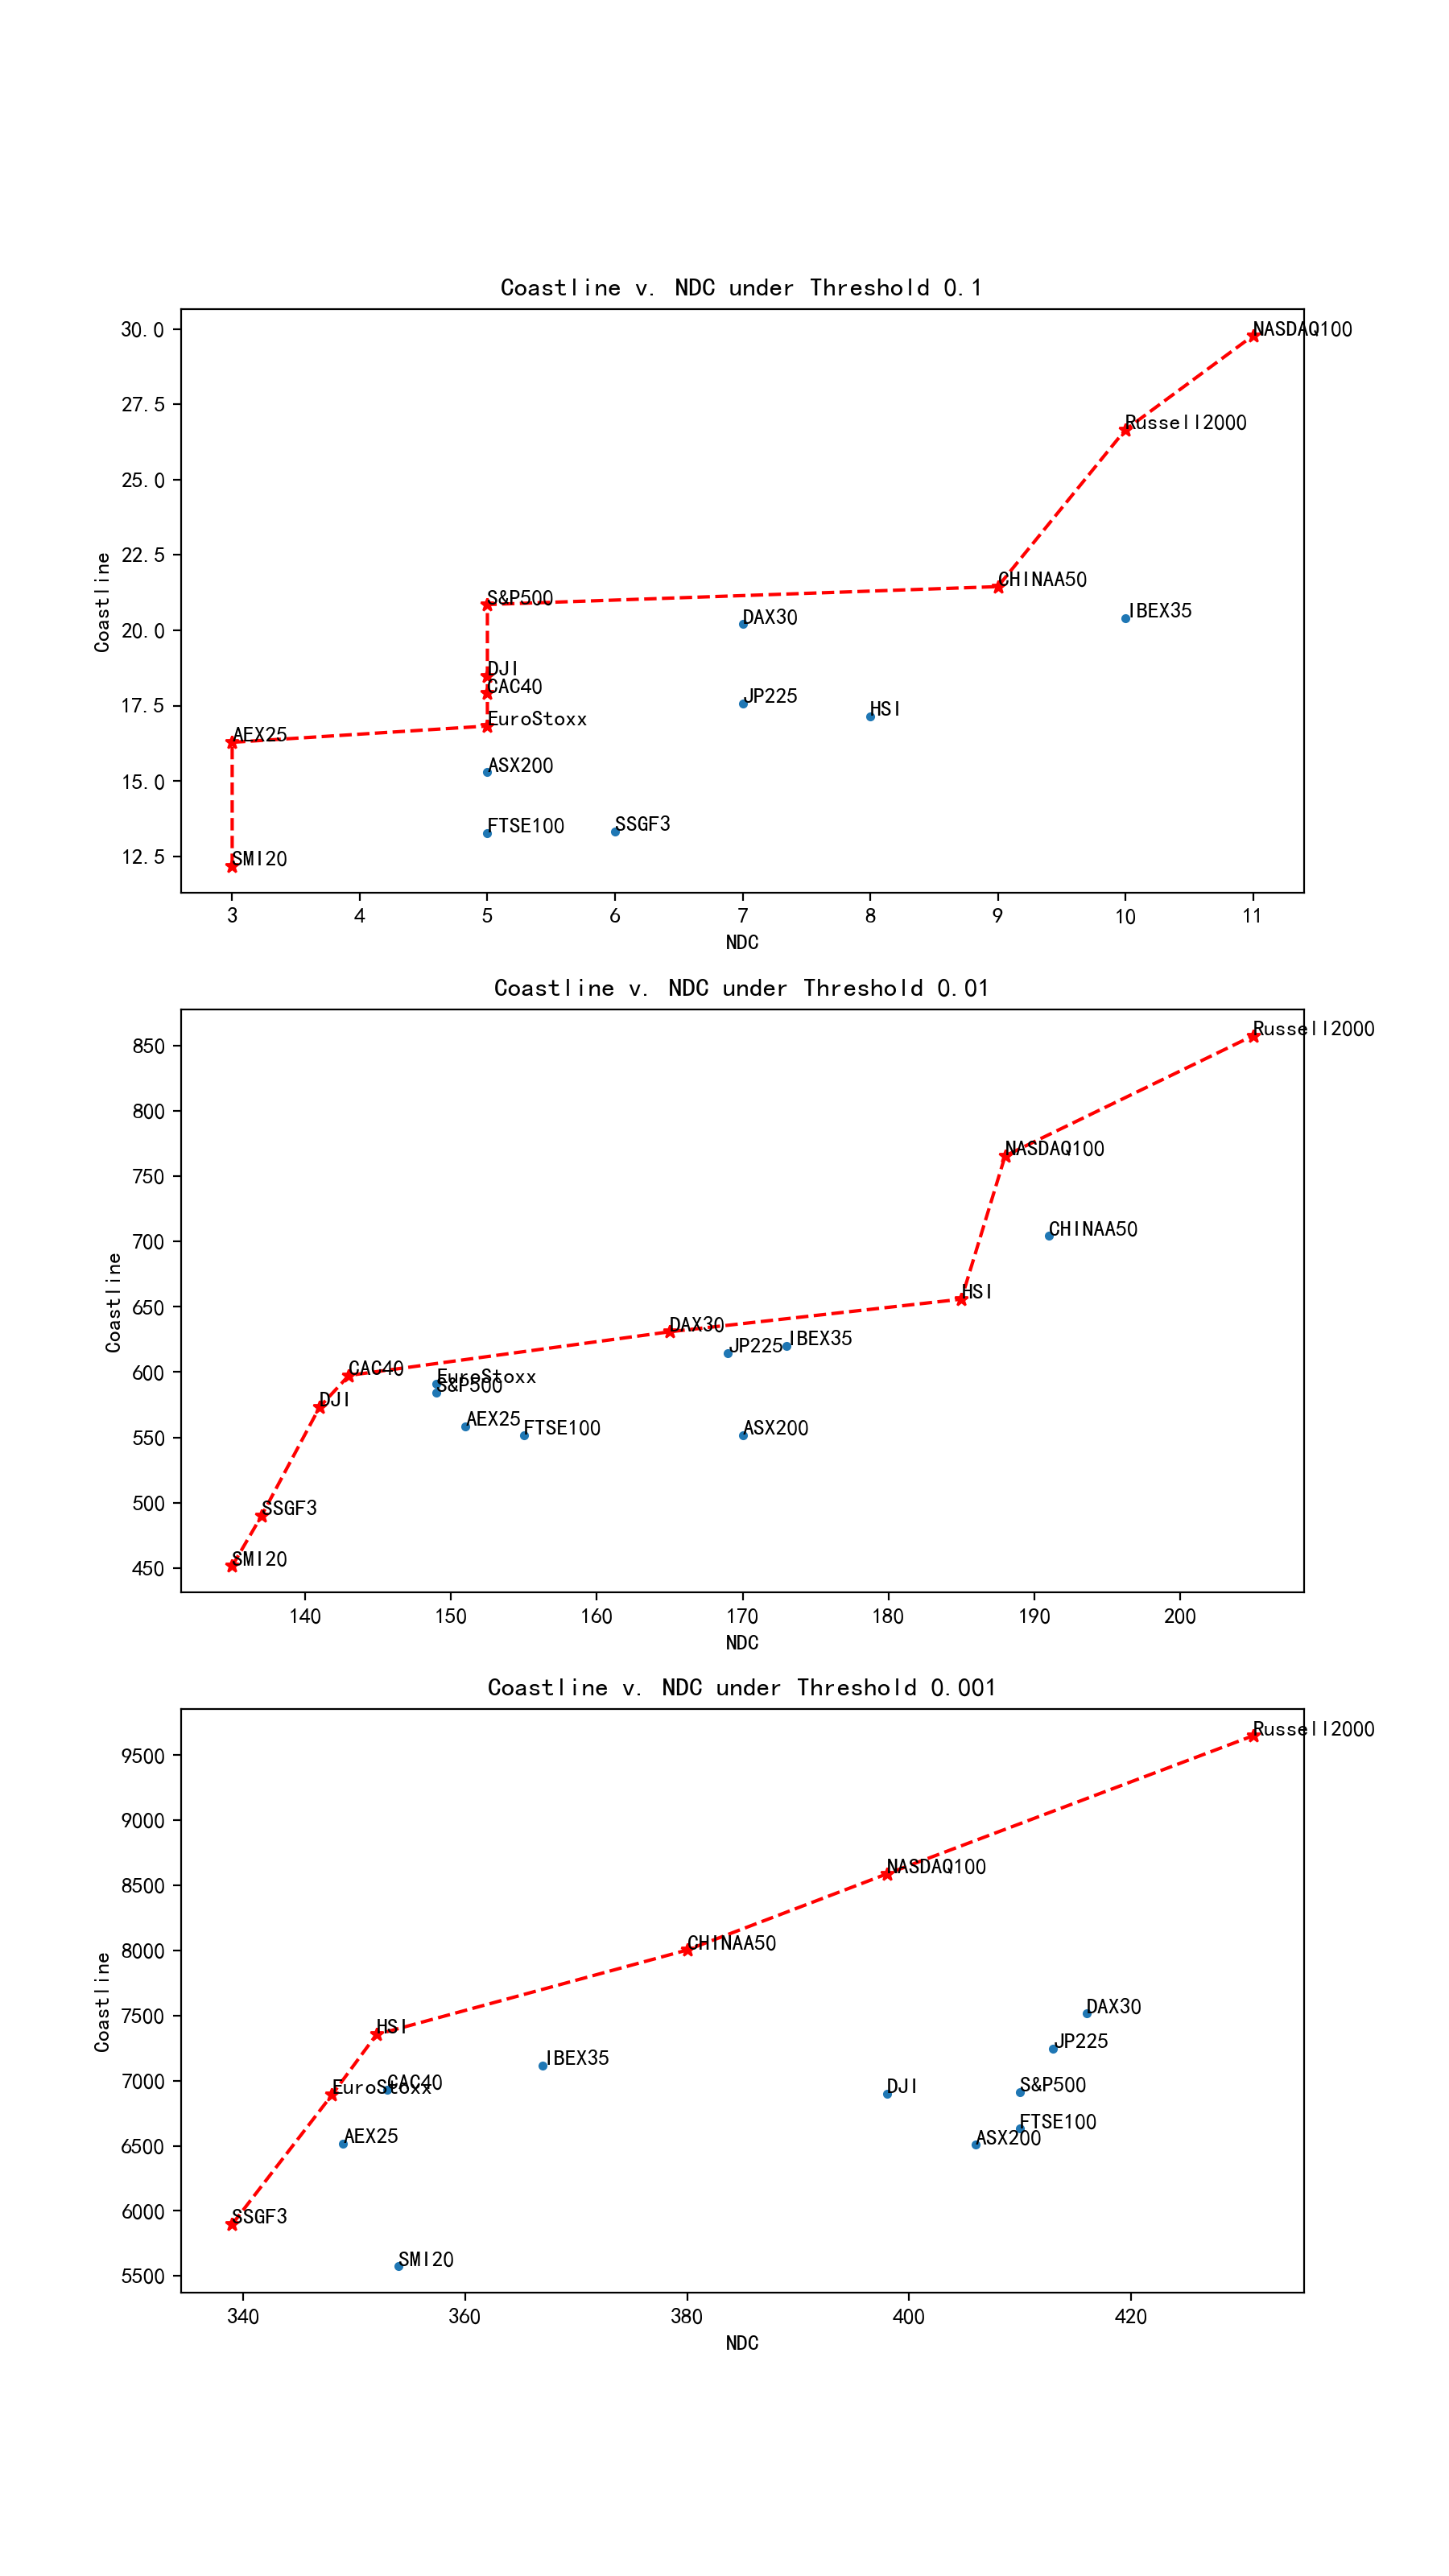

In [89]:
def calculateFrontier(plotPoints):
    '''
    Calculate the competition result of given series of index's (Coastline,NDC) under a certain threshold.
    Return winner and loser, in both index name and corresponding (Coastline,NDC) pair
    '''
    losser=[]
    winner=[]
    
    indexs=plotPoints.index
    for idx,idx_point in enumerate(plotPoints.values):
        
        candidates=plotPoints
        for candidate in candidates:
            
            if idx_point[0]<candidate[0] and idx_point[1]>candidate[1]:
                losser.append((indexs[idx],idx_point))
                break
                
    losserInd=list(zip(*losser))[0]
    for idx,competeIndex in enumerate(indexs):
        if competeIndex not in losserInd:
            winner.append((competeIndex,plotPoints.values[idx]))
            
    return winner,losser

'''
Plot the frontline indexs(in red stars) and dominated indexs(in blue dot), and draw the froneline(in red dash line)
'''
frontline={}
subplotPara=1
plt.figure(figsize=(9,16))
for threshold,col in df_data.items():

    w,l=calculateFrontier(col)
    w=sorted(w,key=lambda x:x[1][0])
    frontline[threshold]={
        'winner':w,
        'losser':l
    }
    if threshold==0.1 or threshold==0.01 or threshold==0.001:
        plt.subplot(3, 1, subplotPara)
        subplotPara+=1
        wX,wY=list(zip(*(map(lambda x:x[1],w))))
        lX,lY=list(zip(*(map(lambda x:x[1],l))))
        
        plt.plot(wY,wX,'r*--')
        plt.scatter(lY,lX,marker='.')
        
        plt.title('Coastline v. NDC under Threshold {}'.format(round(threshold,6)))
        plt.xlabel('NDC')
        plt.ylabel('Coastline')
        for index,(x,y) in col.items():
            plt.text(y,x,index)
plt.show()

<IPython.core.display.Javascript object>


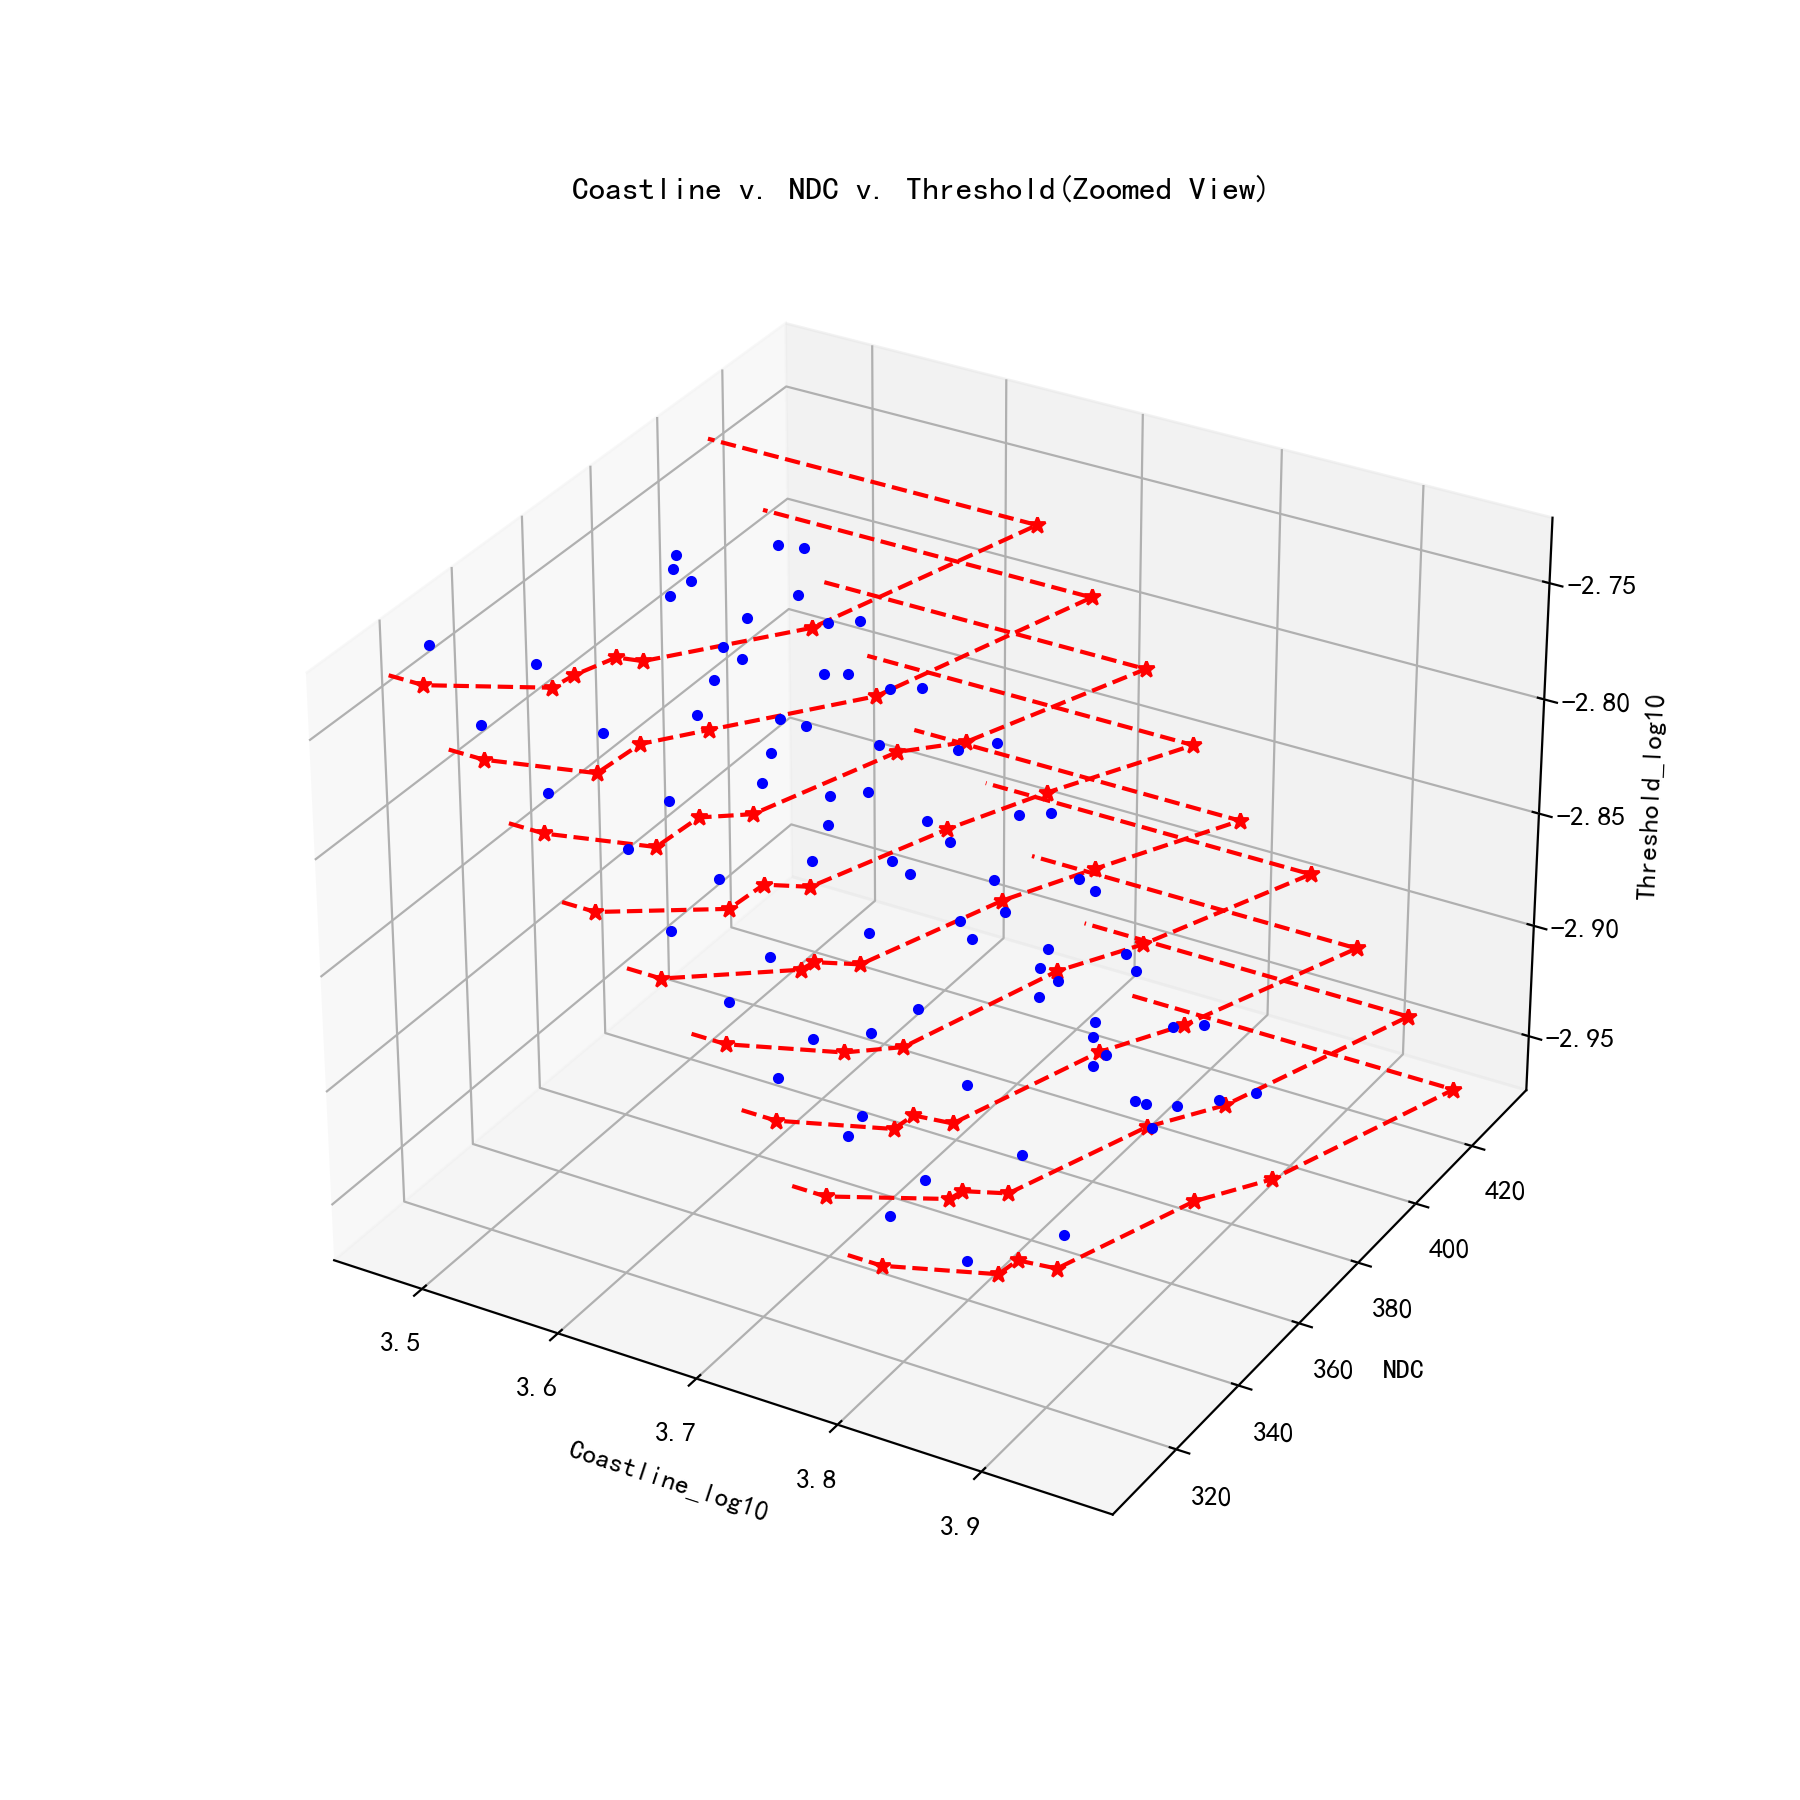

In [96]:
'''
【ZOOMED VERSION】
Plot the 3D view of (Coastline,NDC,Threshold) 
with loser(in blue dot),winner(in red star) and frontline(in red dash line)
Moreover, Two additional points are applied to better demonstrate the enclosure of coastline
And both the thresholds and coastlines are displayed in log10 scale for clear visualization.
'''
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9,9))  # 设置画布大小
ax = plt.axes(projection='3d')
ZZ_thresholds=np.logspace(0,3,100)/10000
winner_surface=[]
for threshold,compete in frontline.items():
# Plot layer by layer
    if 0.001<threshold<0.002:

        #plot loser in a blue dot
        losser=compete['losser']
        losserIndexs,losserPoints=list(zip(*losser))
        losserX,losserY=list(zip(*losserPoints))
        ax.plot(np.log10(losserX),losserY, np.log10(threshold),'b.',label=key) 
        
        #plot winner in red star
        winner=compete['winner']
        winnerIndexs,winnerPoints=list(zip(*winner))
        winnerX,winnerY=list(zip(*winnerPoints))
        ax.plot(np.log10(winnerX),winnerY, np.log10(threshold),'r*',label=key)
        
        # enclose the frontline
        winnerPoints=list(winnerPoints)
        winnerPoints.insert(0,[min(min(losserX),min(winnerX)),winnerPoints[0][1]])
        winnerPoints.append([winnerPoints[0][0],winnerPoints[-1][1]])
        winnerPoints=tuple(winnerPoints)
        winnerX,winnerY=list(zip(*winnerPoints))

        
        # plot the frontline in red dash line.
        ax.plot(np.log10(winnerX),winnerY, np.log10(threshold),'r--',label=key)  # 三个数组对应三个维度（三个数组中的数一一对应）

ax.set_xlabel('Coastline_log10')
ax.set_ylabel('NDC')
ax.set_zlabel('Threshold_log10')
ax.set_title('Coastline v. NDC v. Threshold(Zoomed View)')


plt.show()


<IPython.core.display.Javascript object>


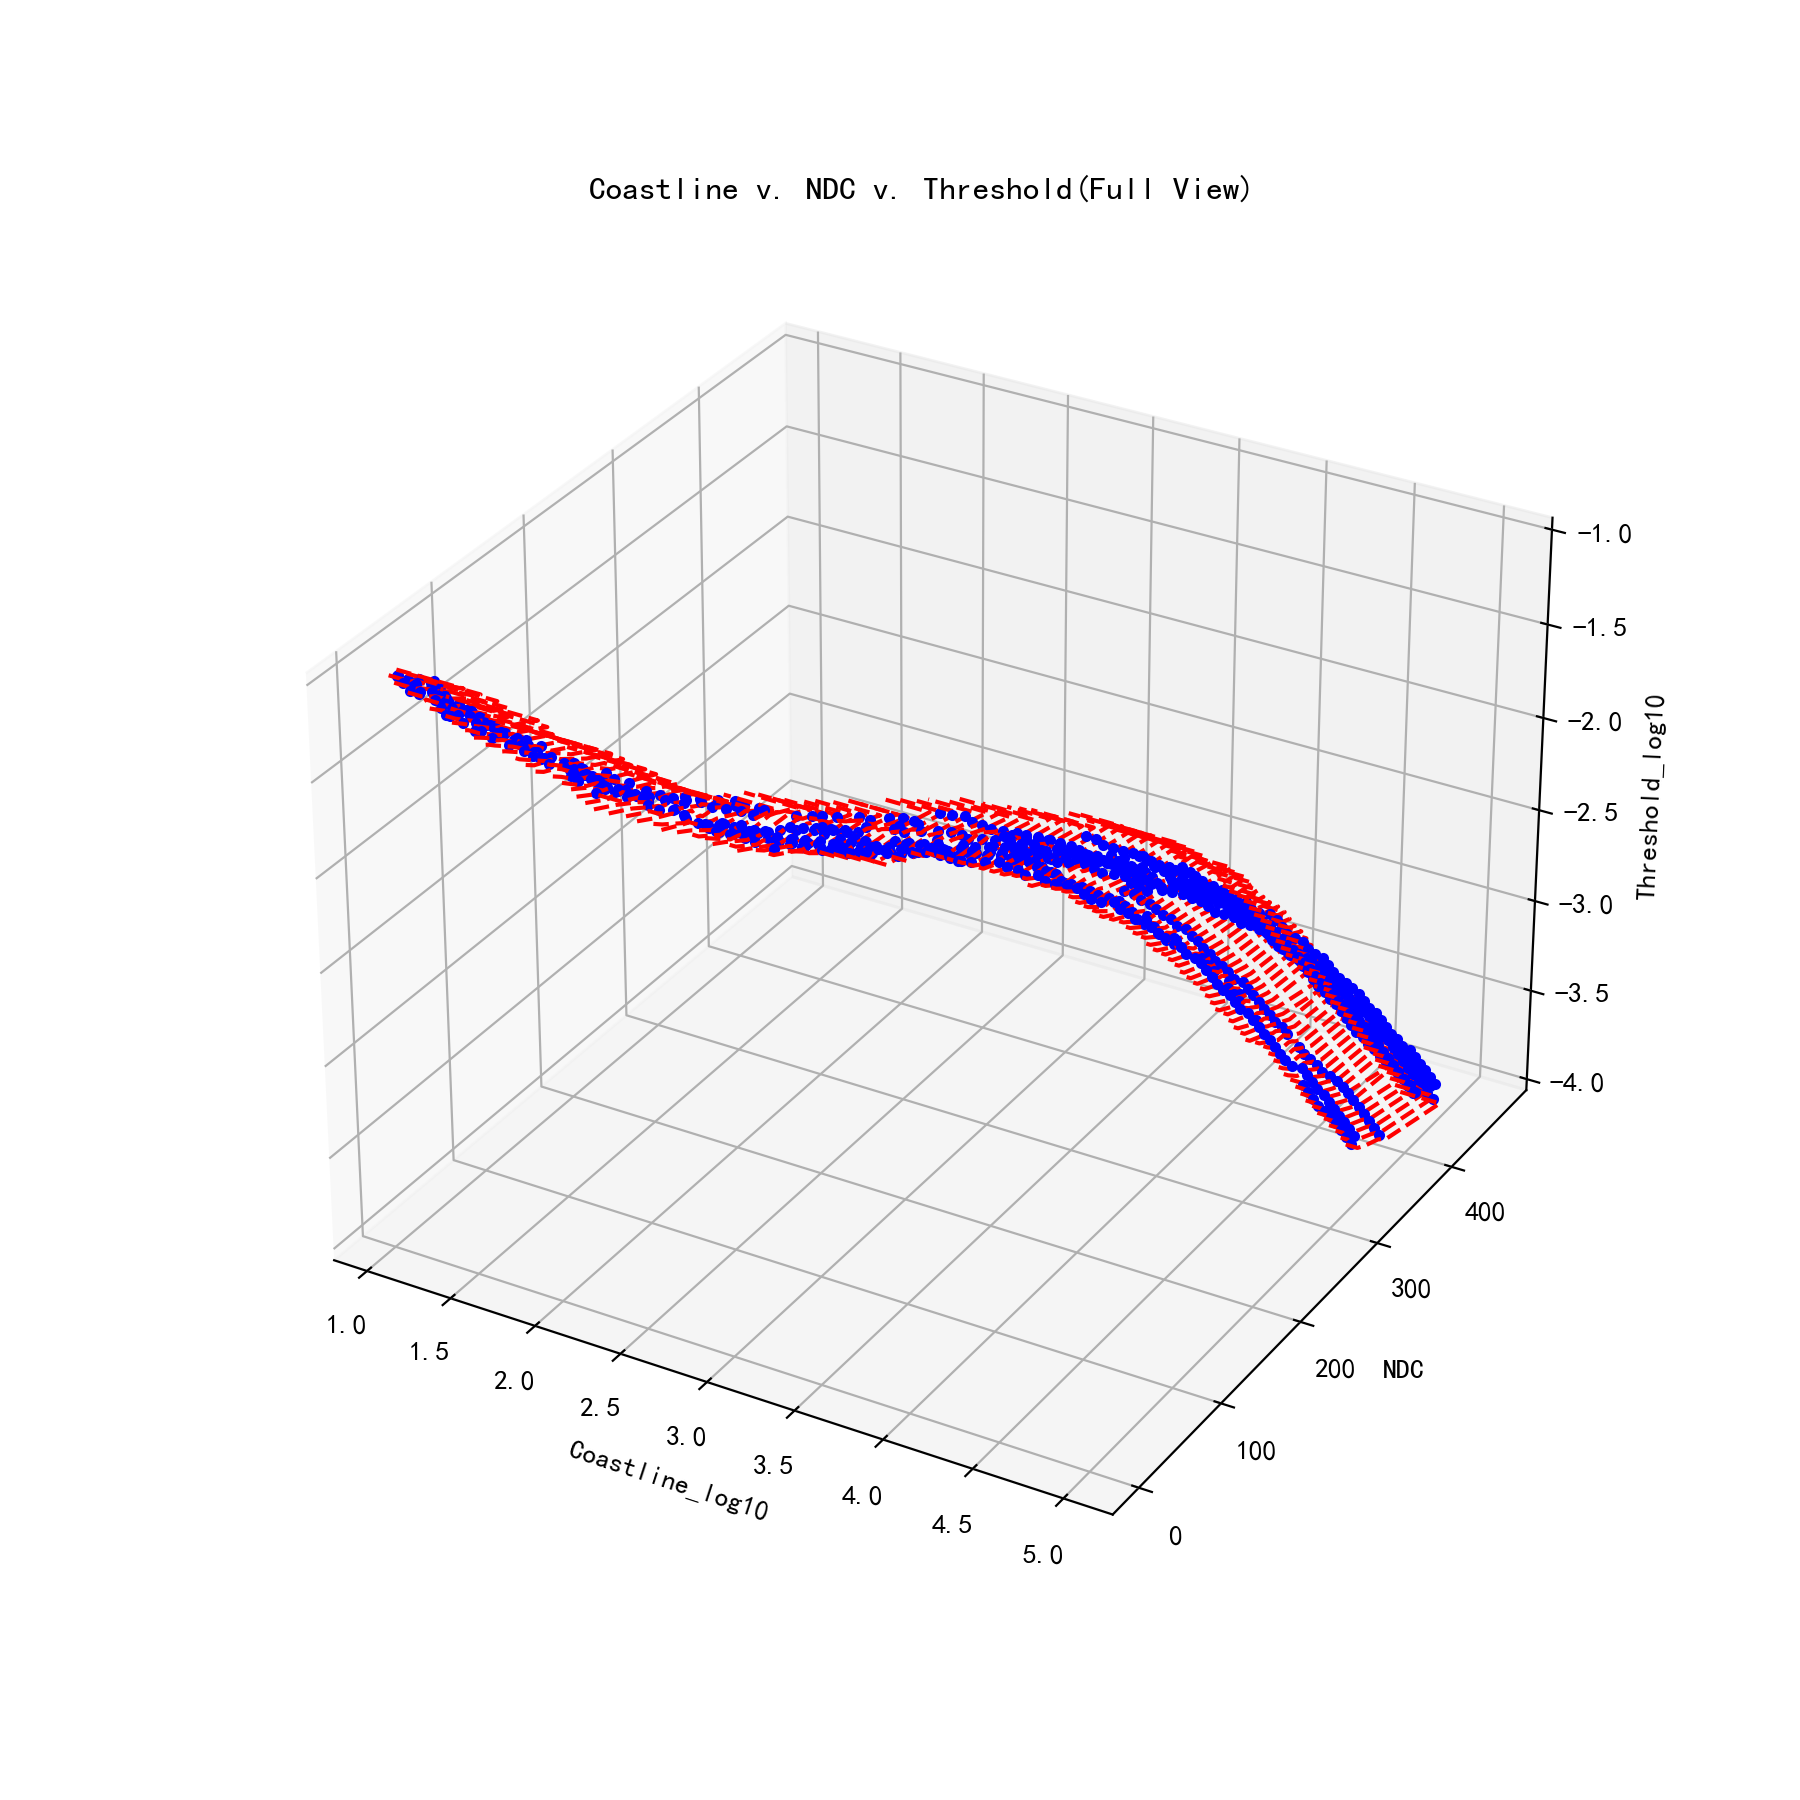

In [98]:
'''
【FULL VERSION】
Plot the 3D view of (Coastline,NDC,Threshold) 
with loser(in blue dot),winner(in red star) and frontline(in red dash line)
Moreover, Two additional points are applied to better demonstrate the enclosure of coastline
And both the thresholds and coastlines are displayed in log10 scale for clear visualization.
'''
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(9,9))  # 设置画布大小
ax = plt.axes(projection='3d')
ZZ_thresholds=np.logspace(0,3,100)/10000
winner_surface=[]
for threshold,compete in frontline.items():
# Plot layer by layer

    #plot loser in a blue dot
    losser=compete['losser']
    losserIndexs,losserPoints=list(zip(*losser))
    losserX,losserY=list(zip(*losserPoints))
    ax.plot(np.log10(losserX),losserY, np.log10(threshold),'b.',label=key) 

    #plot winner in red star
    winner=compete['winner']
    winnerIndexs,winnerPoints=list(zip(*winner))
    winnerX,winnerY=list(zip(*winnerPoints))
#     ax.plot(np.log10(winnerX),winnerY, np.log10(threshold),'r*',label=key)

    # enclose the frontline
    winnerPoints=list(winnerPoints)
    winnerPoints.insert(0,[min(min(losserX),min(winnerX)),winnerPoints[0][1]])
    winnerPoints.append([winnerPoints[0][0],winnerPoints[-1][1]])
    winnerPoints=tuple(winnerPoints)
    winnerX,winnerY=list(zip(*winnerPoints))


    # plot the frontline in red dash line.
    ax.plot(np.log10(winnerX),winnerY, np.log10(threshold),'r--',label=key)  # 三个数组对应三个维度（三个数组中的数一一对应）

ax.set_xlabel('Coastline_log10')
ax.set_ylabel('NDC')
ax.set_zlabel('Threshold_log10')
ax.set_title('Coastline v. NDC v. Threshold(Full View)')


plt.show()


In [94]:
'''
Store the frontline result of all thresholds
'''
df_data_count=df_data.copy()

for threshold,compete in frontline.items():
    winner=compete['winner']
    winnerIndexs,winnerPoints=list(zip(*winner))
    print(threshold,winnerIndexs)
    df_data_count.loc[:,threshold]=np.nan
    for i in winnerIndexs:
        df_data_count.loc[i,threshold]=1

0.1 ('SMI20', 'AEX25', 'EuroStoxx', 'CAC40', 'DJI', 'S&P500', 'CHINAA50', 'Russell2000', 'NASDAQ100')
0.093260334688322 ('SMI20', 'AEX25', 'EuroStoxx', 'DJI', 'CAC40', 'DAX30', 'S&P500', 'CHINAA50', 'NASDAQ100', 'Russell2000')
0.08697490026177834 ('AEX25', 'EuroStoxx', 'S&P500', 'CAC40', 'DAX30', 'CHINAA50', 'NASDAQ100', 'Russell2000')
0.08111308307896872 ('ASX200', 'SMI20', 'AEX25', 'EuroStoxx', 'S&P500', 'CAC40', 'DAX30', 'DJI', 'CHINAA50', 'NASDAQ100', 'Russell2000')
0.0756463327554629 ('ASX200', 'AEX25', 'FTSE100', 'DAX30', 'S&P500', 'CAC40', 'DJI', 'CHINAA50', 'NASDAQ100', 'Russell2000')
0.07054802310718646 ('AEX25', 'DAX30', 'CHINAA50', 'S&P500', 'DJI', 'CAC40', 'NASDAQ100', 'Russell2000')
0.06579332246575682 ('SMI20', 'ASX200', 'AEX25', 'S&P500', 'CHINAA50', 'DJI', 'CAC40', 'NASDAQ100', 'Russell2000')
0.061359072734131756 ('SMI20', 'SSGF3', 'AEX25', 'S&P500', 'DJI', 'CHINAA50', 'CAC40', 'NASDAQ100', 'Russell2000')
0.05722367659350221 ('SSGF3', 'SMI20', 'ASX200', 'AEX25', 'JP225'

/var/folders/1n/w6p5wb715bs51sdgzhrfq9j40000gn/T/ipykernel_5953/1984924234.py:6: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_data_count.loc[:,threshold]=np.nan


In [99]:
df_data_count

,0.100000,0.093260,0.086975,0.081113,0.075646,0.070548,0.065793,0.061359,0.057224,0.053367,...,0.000187,0.000175,0.000163,0.000152,0.000142,0.000132,0.000123,0.000115,0.000107,0.000100
AEX25,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ASX200,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CAC40,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CHINAA50,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
DAX30,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DJI,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EuroStoxx,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
FTSE100,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HSI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
IBEX35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>


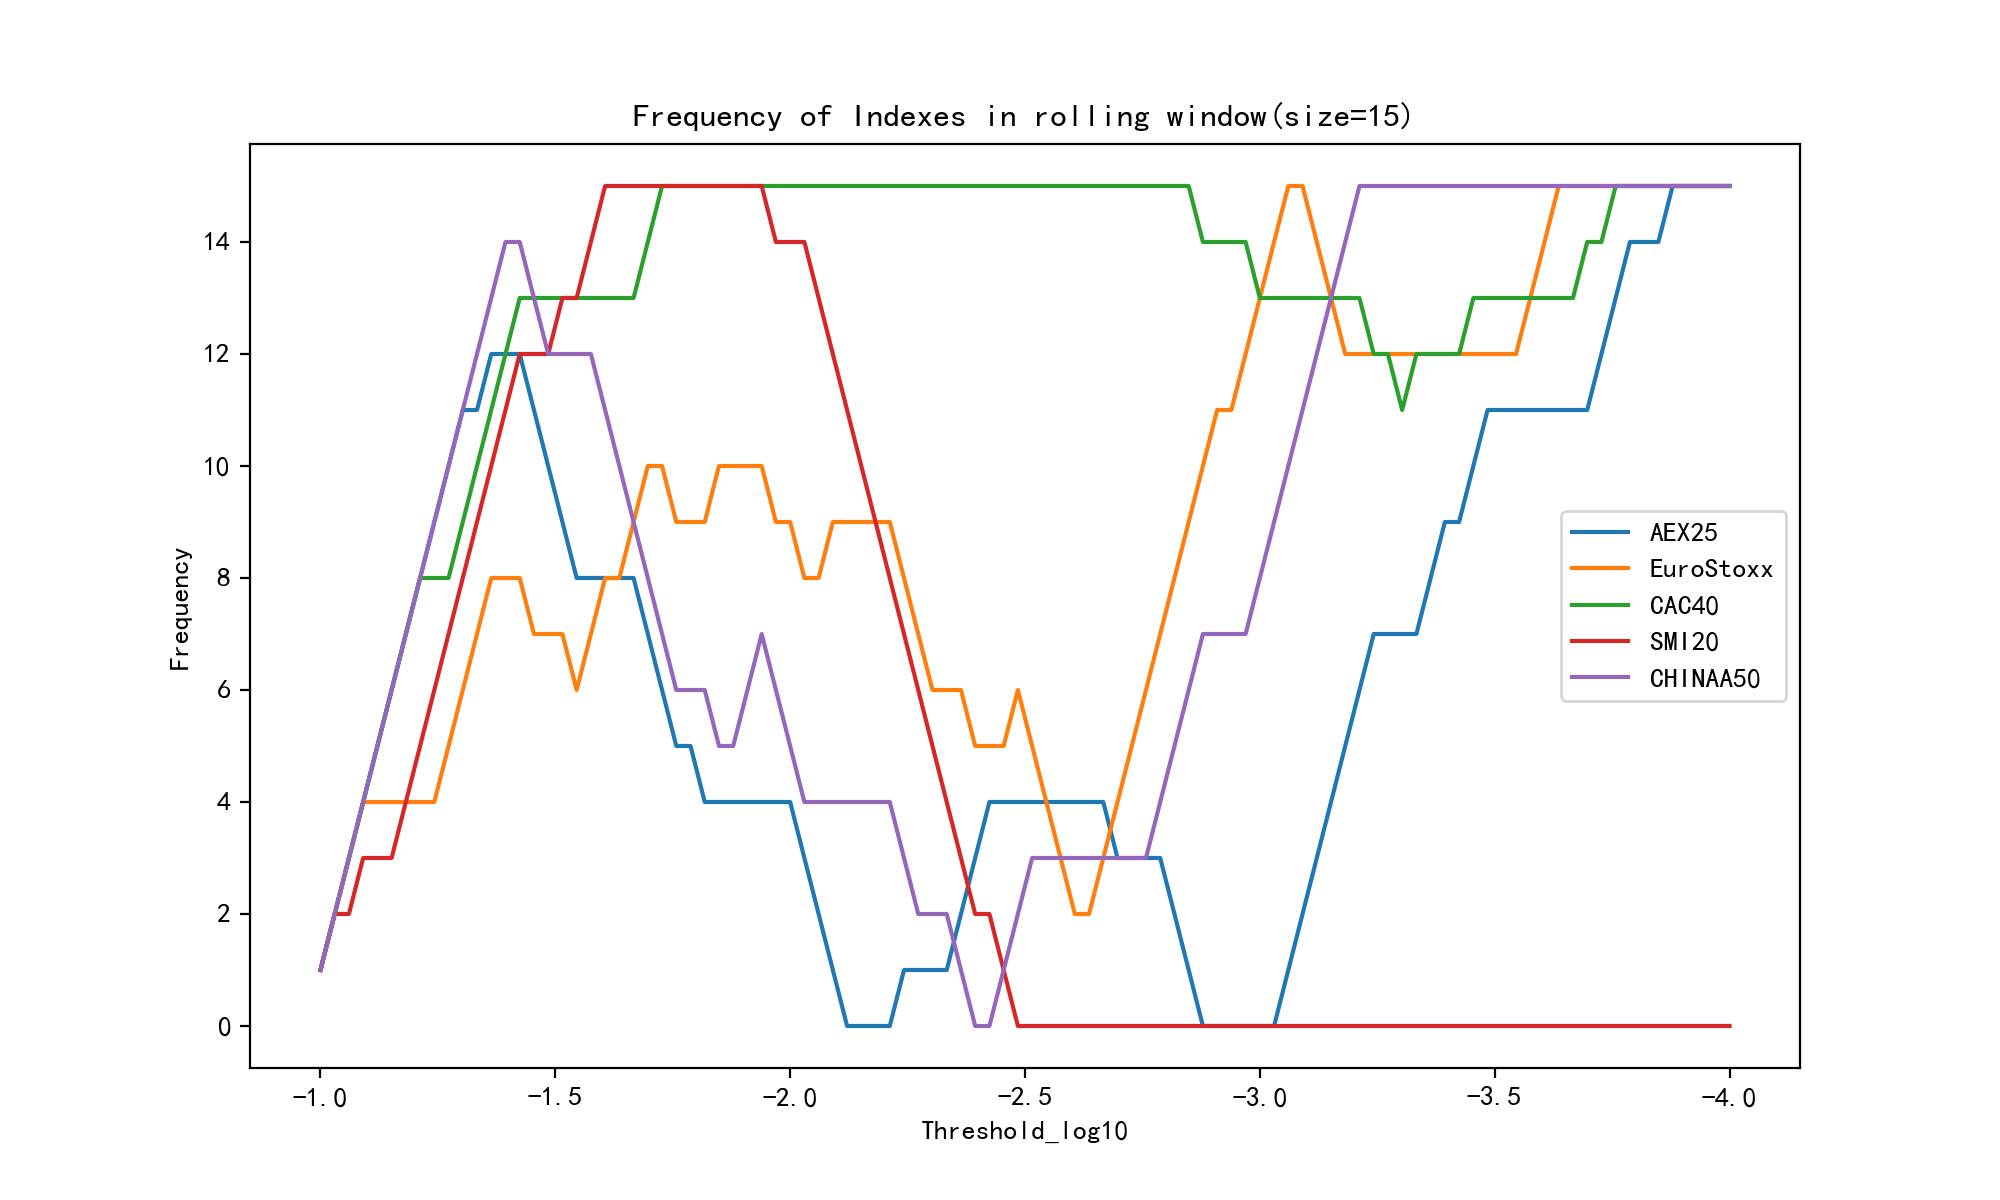

In [100]:
'''
Final result of RFR
'''
windowSize=15
df_new=df_data_count.T
df_new.index=np.log10(df_new.index)

df_new.loc[:,['AEX25', 'EuroStoxx', 'CAC40', 'SMI20', 'CHINAA50']].rolling(windowSize,min_periods=0).count().plot(figsize=(10,6))
plt.gca().invert_xaxis()
plt.xlabel('Threshold_log10')
plt.ylabel('Frequency')
plt.title('Frequency of Indexes in rolling window(size={})'.format(windowSize))
plt.show()